In [ ]:
!pip install -U albumentations==1.4.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.6/214.6 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
# -*- coding: utf-8 -*-
''' Tomato Detection and Classification Script with TensorFlow and Albumentations

Este script permite la detección y clasificación de tomates en imágenes utilizando un modelo de aprendizaje profundo (CNN)
entrenado en TensorFlow. A lo largo del script, se realizan varias etapas de preprocesamiento, aumentación de datos,
entrenamiento del modelo y visualización de resultados.

### Propósito
El script se enfoca en el procesamiento de datos para entrenar un modelo de detección y clasificación, lo que incluye:
- Extracción de imágenes y bounding boxes desde una carpeta.
- Visualización de las bounding boxes sobre las imágenes.
- Aumentación de datos para mejorar la robustez del modelo.
- Normalización de los datos de entrada.
- Definición y entrenamiento de un modelo CNN en TensorFlow para clasificar tomates y predecir las coordenadas de sus bounding boxes.
- Visualización de métricas de rendimiento durante el entrenamiento y predicción en nuevas imágenes.

### Requisitos
- Python 3.9
- TensorFlow 2.17
- OpenCV
- Albumentations 1.4.16
- Matplotlib
- PIL (Python Imaging Library)

### Estructura del Código
1. **Extracción y Visualización de Datos**:
   - `carga_base_de_datos`: Carga las imágenes y sus bounding boxes desde una carpeta específica.
   - `prueba_bounding_box`: Muestra una selección de imágenes junto con sus bounding boxes para verificar la correcta lectura de los datos.

2. **Aumentación de Datos y Normalización**:
   - `formato_bounding_box`: Asegura que los bounding boxes tengan el formato correcto.
   - `aumento_imagen_bounding_box` y `inicio_aumento_de_datos`: Realizan transformaciones aleatorias en las imágenes y bounding boxes.
   - `normalizacion_imagen`: Normaliza los valores de los píxeles de 0-255 a 0-1.
   - `normalizacion_bounding_boxes`: Normaliza las coordenadas de los bounding boxes a valores entre 0 y 1.

3. **Definición del Modelo**:
   - `create_model`: Define un modelo de red neuronal convolucional en TensorFlow para la clasificación de tomates y predicción de bounding boxes.

4. **Entrenamiento del Modelo**:
   - `training_model`: Prepara los datos, realiza padding en las bounding boxes y entrena el modelo en el conjunto de datos normalizado.

5. **Visualización de Métricas**:
   - `graficas_metricas`: Muestra las métricas de rendimiento (loss, accuracy y MSE) durante el entrenamiento y validación.

6. **Predicción y Visualización**:
   - `carga_preparacion_de_imagen`: Carga, redimensiona y normaliza una imagen de entrada para su predicción.
   - `prediccion_dibujo_de_bounding_box`: Realiza una predicción en una imagen nueva, muestra la clase predicha y el bounding box correspondiente.

Created on Mon Oct 01 2024

@author: Carlos Ordoñez '''

' Tomato Detection and Classification Script with TensorFlow and Albumentations\n\nEste script permite la detección y clasificación de tomates en imágenes utilizando un modelo de aprendizaje profundo (CNN)\nentrenado en TensorFlow. A lo largo del script, se realizan varias etapas de preprocesamiento, aumentación de datos,\nentrenamiento del modelo y visualización de resultados.\n\n### Propósito\nEl script se enfoca en el procesamiento de datos para entrenar un modelo de detección y clasificación, lo que incluye:\n- Extracción de imágenes y bounding boxes desde una carpeta.\n- Visualización de las bounding boxes sobre las imágenes.\n- Aumentación de datos para mejorar la robustez del modelo.\n- Normalización de los datos de entrada.\n- Definición y entrenamiento de un modelo CNN en TensorFlow para clasificar tomates y predecir las coordenadas de sus bounding boxes.\n- Visualización de métricas de rendimiento durante el entrenamiento y predicción en nuevas imágenes.\n\n### Requisitos\n- 

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Función para extraer datos de las carpetas
def carga_base_de_datos(folder):
    imagen = []
    etiquetas = []

    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):  # Si es una imagen
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path) # Extraer los datos de los pixeles dentro del archivo
            '''openCV por defecto extrae los valores de los pixeles en el formato BGR el cual tiene mayor gama de colores
            dato necesario por si se necesita visualizar las imagenes en RGB sera necesario una conversion'''
            imagen.append(image)

            # Busca el archivo XML correspondiente
            xml_file = os.path.splitext(filename)[0] + '.xml' # Si es un archivo de texto
            xml_path = os.path.join(folder, xml_file)

            if os.path.exists(xml_path):
                # Cargar el archivo XML y extraer los datos
                tree = ET.parse(xml_path)
                root = tree.getroot()

                '''Del archivo en formato Pascal Voc se deben extraer 5 datos los cuales son: label, xmin, xmax, ymin, ymax
                estos valores en texto se deben convertir a valores numericos y despues anexarlos a una lista'''

                boxes = []
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    boxes.append((label, xmin, ymin, xmax, ymax))

                etiquetas.append(boxes)

    return imagen, etiquetas

In [ ]:
# Cargar los datos de las carpetas de test, train y validación (VisualCode)
train_imagen, train_etiquetas = carga_base_de_datos('/content/drive/MyDrive/Colab_Notebooks/Classification/DatasetSuper/train')
test_imagen, test_etiquetas = carga_base_de_datos('/content/drive/MyDrive/Colab_Notebooks/Classification/DatasetSuper/valid')

In [ ]:
'''Una imagen mas grande usa mas recursos por lo que se define el tamano optimo segun el caso'''
TAMANO_IMAGEN=224

In [ ]:
'''Es importante poder confirmar que las imagenes tiene correctamente sus caja delimitadoras por lo que poder visualizar algunas para
confirmar que estan se estan leyendo de la forma correcta es algo necesario'''
# Función para visualizar imágenes con sus cajas delimitadoras
def prueba_bounding_box(image_paths, etiquetas):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()  # Flatten la matriz de ejes para iterar fácilmente

    for i in range(9):
        image = (image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Conversion de formato de colores
        axs[i].imshow(image)

        # Dibujar las cajas delimitadoras
        for box in etiquetas[i]:
            label, xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)
            axs[i].text(xmin, ymin - 10, label, color='red', fontsize=12, weight='bold')

        axs[i].axis('off')  # Ocultar los ejes para una visualización más limpia

    plt.tight_layout()
    plt.show()

Imagenes de entrenamiento


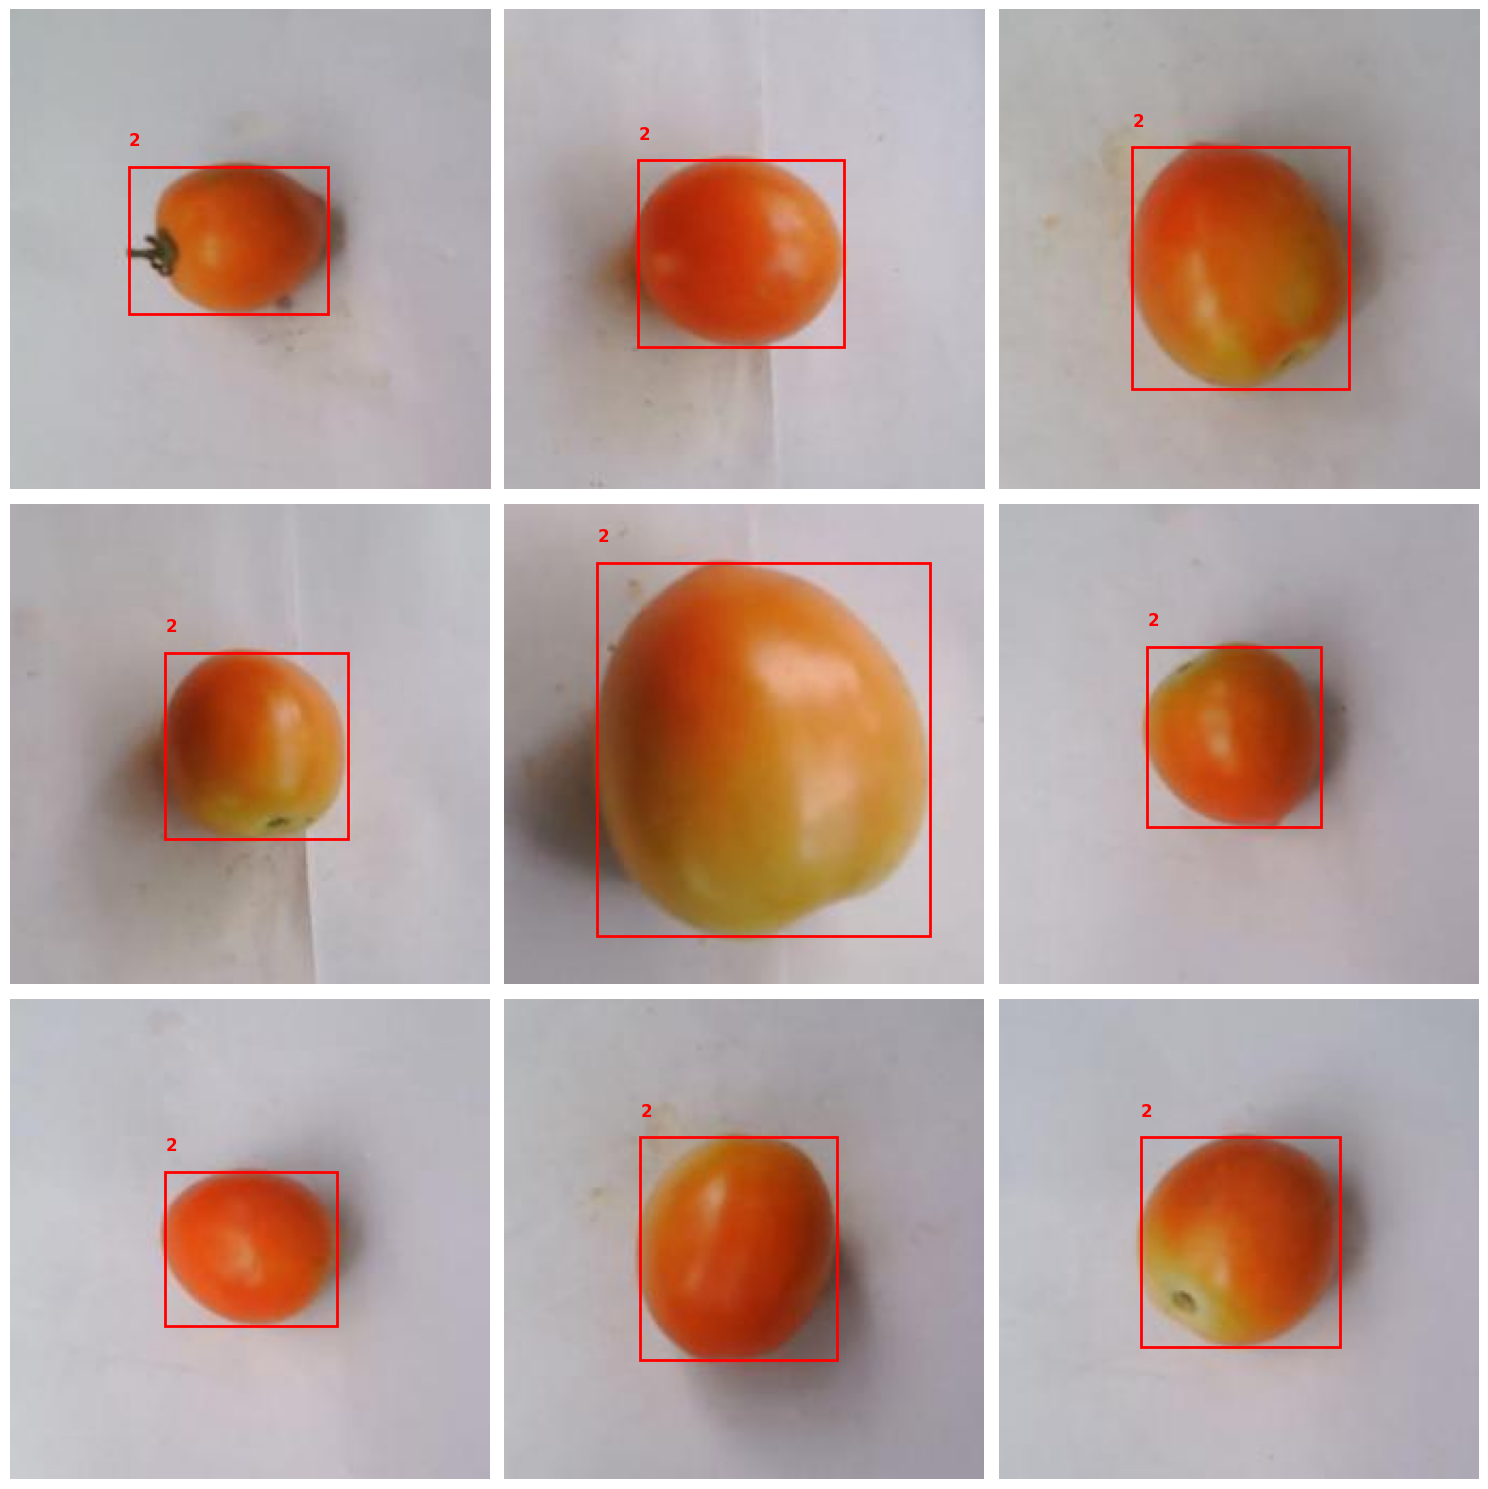

In [ ]:
# Plot para visualizar las imágenes de entrenamiento
print('Imagenes de entrenamiento')
prueba_bounding_box(train_imagen[:9], train_etiquetas[:9])

Imagenes de testeo


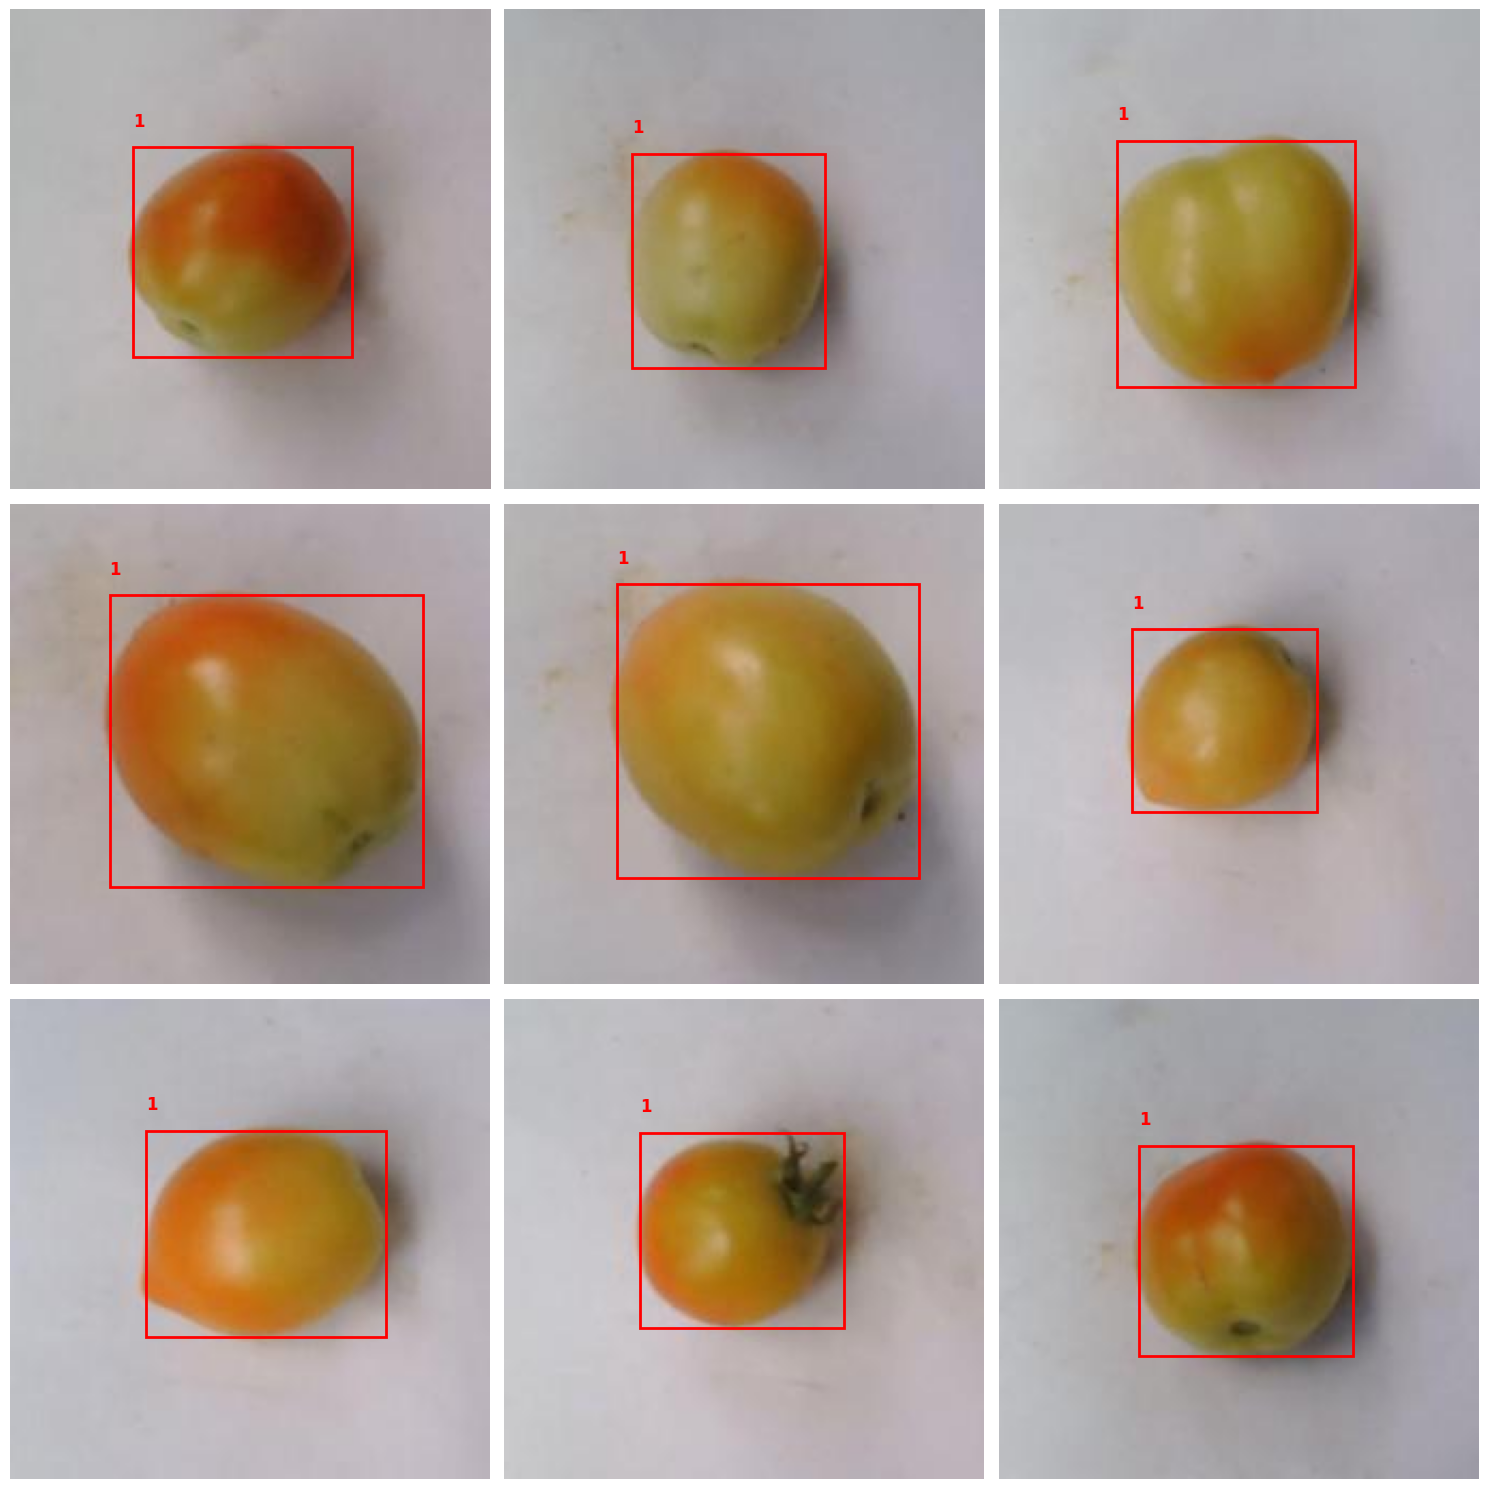

In [ ]:
# Plot para visualizar las imágenes de test
print('Imagenes de testeo')
prueba_bounding_box(test_imagen[150:159], test_etiquetas[150:159])

In [ ]:
'''Las imagenes vienen en un formato de pixeles con un rango de valores 0-255, sin embargo el modelo
de aprendizaje usa el framework de Tensorflow por lo que es necesario normalizar a valores de 0-1'''
# Función para normalizar las imágenes
def normalizacion_imagen(imagen):
    # Necesario asegurar que la normalizacion se esta realizando a numeros flotantes
    imagen_normalizada = np.array(imagen).astype(float) / 255.0
    return imagen_normalizada

In [ ]:
# Llamado a la normalizacion
test_imagen_normalizada = normalizacion_imagen(test_imagen)

In [ ]:
# Visualizacion de la correcta normalizacion de las imagenes
print(test_imagen_normalizada[:2])

[[[[0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   ...
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]]

  [[0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   ...
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]]

  [[0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   [0.69411765 0.69019608 0.69803922]
   ...
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]
   [0.77647059 0.75294118 0.75686275]]

  ...

  [[0.61568627 0.61960784 0.63529412]
   [0.61568627 0.61960784 0.63529412]
   [0.61176471 0.61568627 0.63137255]
   ...
   [0.75294118 0.73333333 0.7372549 ]
   [0.75294118 0.73333333 0.7372549 ]
   [0.75294118 0.73333333 0.7372549 ]]

  [[0.61568627 0.61960784 0.63529412]
   [0.6

In [ ]:
'''Un paso muy importante en el entrenamiento es el aumento de datos en las imagenes pero estas al tener bounding boxes se
debe asegurar que si la imagen sufre alguna transformacion las coordenadas sufran la misma transformacion. Se usa la libreria de albumentation
y esta trabaja con valores de pixeles de 0-255 por lo que las imagenes para entrenar no fueron normalizadas'''

# Función para asegurar el formato correcto de los bounding boxes
def formato_bounding_box(bboxes):
    bounding_box_reformado = []
    for bbox in bboxes:
        if len(bbox) == 5:
            class_label, xmin, ymin, xmax, ymax = bbox # Asegurar que las etiqueas se encuentran en Pascal VOC
            try:
                '''Las coordenadas estan aguardadas como valores enteros pero al aplicar le aumento de datos a las imagenes estas
                pueden alteran la posicion de las bounding boxes y pueden quedar en valores flotantes por lo que convertimos las
                coordenadas previamente guardadas de enteros a flotante de no ser así identificamos el error'''
                bounding_box_reformado.append([class_label, float(xmin), float(ymin), float(xmax), float(ymax)])
            except ValueError:
                print(f'Error al convertir las coordenadas a flotantes: {bbox}')
                '''En caso de que este error se muestre en pantalla se debe de identificar que todas las coordenadas se encuentran
                en valores numericos asi que es importante verificar que los caracteres sea los correctos'''
        else:
            print(f'Bounding box no tiene los valores esperados: {bbox}')
            '''Este error se puede deber a que la funcion espera 5 datos en la lista como lo es la clase y las 4 coordenadas,
            en caso de que este dublicada alguna coordenada mostrara que el formato es incorrecto'''
    return bounding_box_reformado # Devuelve la lista de bounding boxes formateados

# Funcion para aplicar el aumento de datos a una imagen y sus bounding boxes
def aumento_imagen_bounding_box(image, bboxes):
    # Antes de la transformcion se asegura que las bounding boxes tengan el formato correcto
    bboxes = formato_bounding_box(bboxes)

    '''Define una serie de transformaciones utilizando la librería albumentations (A).
    Las transformaciones incluyen cambios aleatorios como recortes, giros, ajustes de brillo, y redimensionado.'''
    transform = A.Compose([
        A.RandomSizedBBoxSafeCrop(width=TAMANO_IMAGEN, height=TAMANO_IMAGEN, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.MedianBlur(blur_limit=7, p=0.5),
        A.RandomRotate90(p=0.5),
        A.Resize(TAMANO_IMAGEN, TAMANO_IMAGEN),  # Redimensionar las imágenes de vuelta a su tamaño si se alteran
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['etiquetas_clase'],min_area=TAMANO_IMAGEN,))

    try:
        etiquetas_clase = [bbox[0] for bbox in bboxes] # Guardar la etiqueta de clase
        valores_bounding_box = [bbox[1:] for bbox in bboxes] # Guardar los valores de las coordenadas
        '''Una vez separados los elelemntos de la imagen en variables diferntes asi como lo es
        la imagen, su clase y sus coordenadas procedemos a la transformacion'''
        aumentado = transform(image=image, bboxes=valores_bounding_box, etiquetas_clase=etiquetas_clase)
    except Exception as e:
        print(f'Error al aplicar la transformación: {e}')
        '''Este error se puede deber a que al transformar alguna transformacion dimenciono la imagen a un tamaño no
        acceptable o se modifico algunas coordenadas y se eliminaron como es el caso cuando el bounding box queda
        por fuera de la imagen'''
        return image, bboxes

    # Combina nuevamente las etiquetas de clase con las coordenadas de los bounding boxes transformados
    new_bboxes = [[etiquetas_clase[i]] + list(bbox) for i, bbox in enumerate(aumentado['bboxes'])]

    return aumentado['image'], new_bboxes

# Funcion para aplicar el aumento de datos a todas las imágenes y sus bounding boxes
def inicio_aumento_de_datos(imagen, etiquetas):
    aumentado_imagen = []
    aumentado_bboxes = []

    for image, bboxes in zip(imagen, etiquetas):
        new_image, new_bboxes = aumento_imagen_bounding_box(image, bboxes)
        aumentado_imagen.append(new_image) # Imagenes ya transformadas
        aumentado_bboxes.append(new_bboxes) # Bounding boxes ya transformadas

    return aumentado_imagen, aumentado_bboxes

# Llamado al inicio de transformacion
imagen_train_aumentada, bounding_box_train_aumentado = inicio_aumento_de_datos(train_imagen, train_etiquetas)

In [ ]:
# Llamado a la normalizacion de imagenes despues de aumento de datos
train_imagen_normalizada = normalizacion_imagen(imagen_train_aumentada)
print(train_imagen_normalizada[:2])

[[[[0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   ...
   [0.68627451 0.65882353 0.68627451]
   [0.68627451 0.65882353 0.68627451]
   [0.69019608 0.6627451  0.69019608]]

  [[0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   ...
   [0.68627451 0.65882353 0.68627451]
   [0.68627451 0.65882353 0.68627451]
   [0.69019608 0.6627451  0.69019608]]

  [[0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   [0.74901961 0.74509804 0.72941176]
   ...
   [0.68627451 0.65882353 0.68627451]
   [0.68627451 0.65882353 0.68627451]
   [0.69019608 0.6627451  0.69019608]]

  ...

  [[0.69803922 0.69803922 0.6745098 ]
   [0.70196078 0.70196078 0.67843137]
   [0.70196078 0.70196078 0.67843137]
   ...
   [0.68235294 0.6627451  0.66666667]
   [0.68235294 0.6627451  0.66666667]
   [0.68235294 0.6627451  0.66666667]]

  [[0.69803922 0.69803922 0.6745098 ]
   [0.6

In [ ]:
'''Las imagenes ya fueron normalizadas sin embargo las coordenadas de las bounding boxes no y estas siguen teniendo valores
enteros de los pixeles por lo que sus coordenadas ya no sirven para el nuevo formato normalizado de las imagenes
asi que se normaliza las coordenadas para esto se divide el valor de la coordenada entre los valores de la dimension de
la imagen'''
def normalizacion_bounding_boxes(bboxes, image_width=TAMANO_IMAGEN, image_height=TAMANO_IMAGEN):

    normalizado_boxes = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox

        # Normalización
        normalizado_xmin = xmin / image_width
        normalizado_ymin = ymin / image_height
        normalizado_xmax = xmax / image_width
        normalizado_ymax = ymax / image_height

        normalizado_boxes.append((normalizado_xmin, normalizado_ymin, normalizado_xmax, normalizado_ymax))

    return normalizado_boxes

In [ ]:
# Funcion para normalizar las coordenadas de los bounding boxes de entrenamiento
'''Para poder normalizar todas las coordenadas de los bounding boxes de entrenamiento se tiene
que iterar en cada una de las coordenadas guardadas en la variable por lo que se recorre una por una
y los ciclos de iteraciones dependen de la cantidad de coordenadas guardadas en la lista de coordenadas'''
def train_etiquetas_normalizado(bounding_box_train_aumentado):
  bounding_box_train_aumentado_normalizado = []
  for bbox_list in bounding_box_train_aumentado:
      normalizado_bbox_list = normalizacion_bounding_boxes([bbox[1:] for bbox in bbox_list])
      aumentado_normalizado = [[bbox_list[i][0]] + list(normalizado_bbox_list[i]) for i in range(len(bbox_list))]
      bounding_box_train_aumentado_normalizado.append(aumentado_normalizado)
  return bounding_box_train_aumentado_normalizado

bounding_box_train_normalizado=train_etiquetas_normalizado(bounding_box_train_aumentado)
print(bounding_box_train_normalizado[:2]) # Mostrar las primeras anotaciones normalizadas para verificar

[[['2', 0.24553571428571427, 0.36607139451163156, 0.6607142857142857, 0.6741071428571429]], [['2', 0.29464285714285715, 0.29910714285714285, 0.7232142857142857, 0.6875]]]


In [ ]:
# Funcion para normalizar las coordenadas de los bounding boxes de test
'''Para poder normalizar todas las coordenadas de los bounding boxes de validacion se tiene
que iterar en cada una de las coordenadas guardadas en la variable por lo que se recorre una por una
y los ciclos de iteraciones dependen de la cantidad de coordenadas guardadas en la lista de coordenadas'''
def test_etiqueta_normalizado(test_etiquetas):
  test_etiquetas_normalizado = []
  for bbox_list in test_etiquetas:
      normalizado_bbox_list = normalizacion_bounding_boxes([bbox[1:] for bbox in bbox_list])
      aumentado_normalizado = [[bbox_list[i][0]] + list(normalizado_bbox_list[i]) for i in range(len(bbox_list))]
      test_etiquetas_normalizado.append(aumentado_normalizado)
  return test_etiquetas_normalizado

bounding_box_test_normalizado=test_etiqueta_normalizado(test_etiquetas)  # Mostrar las primeras anotaciones normalizadas para verificar
print(bounding_box_test_normalizado[:2])

[[['1', 0.22321428571428573, 0.23660714285714285, 0.9107142857142857, 0.8928571428571429]], [['2', 0.4017857142857143, 0.19196428571428573, 0.59375, 0.47767857142857145]]]


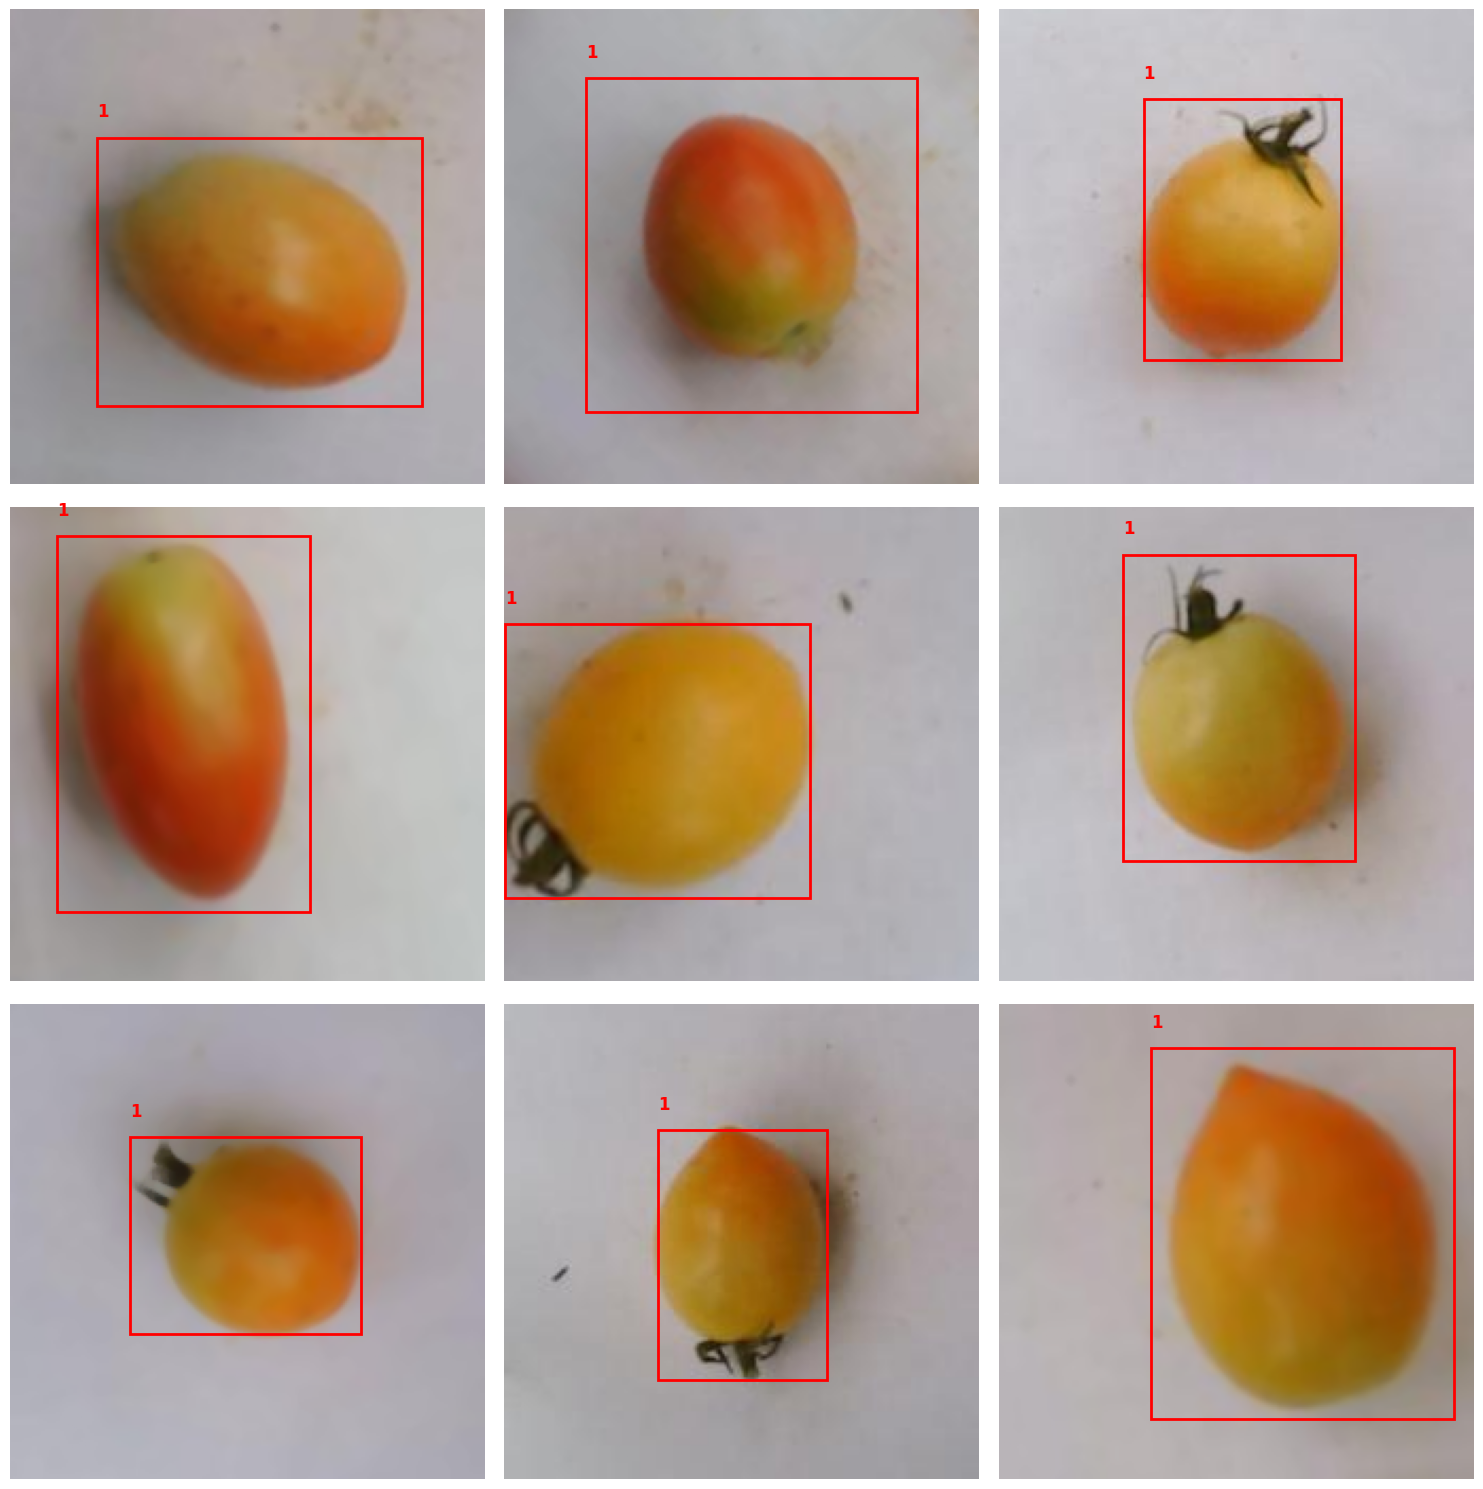

In [ ]:
'''Plot para visualizar las imagenes y los bounding boxes transformados y normalizados pero las coordenadas
necesian volver a su valor enteros para que estos puedan ser agregados a la imagen de forma visual por lo que se
hace la operacion inversa a la normalizacion (multiplicacion)'''

def plot_imagen_con_bounding_box(imagen, etiquetas, num_imagen=9, image_size=TAMANO_IMAGEN):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()  # Flatten la matriz de ejes para iterar fácilmente

    for i in range(min(num_imagen, len(imagen))):
        image = imagen[i].astype('float32') # Convert image to float32
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = (imagen[i])
        axs[i].imshow(image)

        for bbox in etiquetas[i]:
            class_label, xmin, ymin, xmax, ymax = bbox
            # Convertir las coordenadas normalizadas a píxeles
            xmin = xmin * image_size
            ymin = ymin * image_size
            xmax = xmax * image_size
            ymax = ymax * image_size

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)
            axs[i].text(xmin, ymin - 10, class_label, color='red', fontsize=12, weight='bold')

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Llamar a la función con las imágenes y bounding boxes normalizados
plot_imagen_con_bounding_box(train_imagen_normalizada[1100:1109], bounding_box_train_normalizado[1100:1109])


In [ ]:
'''Aqui inicia la creacion del modelo, para este modelo de machine learning se decidio usar el framework de Tensorflow
ya que este ofrece mayor versatibilidad para los tipos de datos que se estan usando y permite una gran personalizacion
para poder estar ajustando a los parametros'''
# Definimos el tamaño de la entrada: (tamaño de las imágenes) con 3 canales (RGB)
input_shape = (TAMANO_IMAGEN, TAMANO_IMAGEN, 3)
num_classes = 3  # Ajusta según la cantidad de clases que tenga, en este caso 3

'''Se usaran tres capas convulucionales como entrada de los datos, se escogio tres capas y con un cremento de 2x en
el numero de neuronas iniciando por 32 para poder obtener los patrones complejos de las imagenes pero sin
sobreajustar al modelo'''
# Definir el modelo CNN
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Bloque 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Bloque 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Bloque 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Aplanar
    x = Flatten()(x)

    '''Se uso una unica capa densa ya que con una es suficiente para unir los patrones complejos del entrenamiento
    sin sobreajustar el modelo, al igual que se escogio solo 32 neuronas ya que se buscan patrones complejos
    pero no se cuenta con una set de entrenamiento grande'''
    # Capa completamente conectada
    x = Dense(32, activation='relu',kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.4)(x)

    # Predicciones de la clase
    class_output = Dense(num_classes, activation='softmax', name='class_output')(x)

    # Predicciones del bounding box (xmin, ymin, xmax, ymax)
    bbox_output = Dense(4, activation='linear', name='bbox_output')(x)

    # Definir el modelo con dos salidas
    model = Model(inputs=inputs, outputs=[class_output, bbox_output])

    return model

# Crear el modelo
model = create_model(input_shape=input_shape, num_classes=num_classes)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.000015),
                loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
                metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# Resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 28, 28, 128)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 100352)         │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │      3,211,296 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 3)              │             99 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,304,775 (12.61 MB)

 Trainable params: 3,304,775 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
''''Aqui se inicia con el entrenamiento del modelo, para esto se toman las variables donde se guardan las imagenes y etiquetas
ya normalizadas tanto del entrenamiento como las del test'''
def training_model(train_imagen_normalizada, bounding_box_train_normalizado, test_imagen_normalizada, bounding_box_test_normalizado):
    #Extraccion de datos para entrenamiento
    y_class_train = []
    y_bbox_train = []

    max_bboxes = max([len(bboxes) for bboxes in bounding_box_train_normalizado])  # Número máximo de bounding boxes en el conjunto de entrenamiento

    # Recorrer las anotaciones de entrenamiento y separar las clases y bounding boxes
    for ann in bounding_box_train_normalizado:
        etiquetas_clase = [bbox[0] for bbox in ann]  # Extraer clases
        bboxes = [bbox[1:] for bbox in ann]       # Extraer bounding boxes (coordenadas)

        # Hacer padding a las clases y bounding boxes
        etiquetas_clase += [-1] * (max_bboxes - len(etiquetas_clase))  # Padding para las clases
        bboxes += [[0, 0, 0, 0]] * (max_bboxes - len(bboxes))   # Padding para los bounding boxes

        y_class_train.append(etiquetas_clase)
        y_bbox_train.append(bboxes)

    # Convertir las listas a arrays de NumPy y asegurarse de que tengan el tipo de dato correcto
    y_class_train = np.array(y_class_train, dtype=np.int32)  # Clases deben ser enteros
    y_bbox_train = np.array(y_bbox_train, dtype=np.float32)  # Bounding boxes deben ser float32

#Extraccion de datos para validacion o test
    y_class_test = []
    y_bbox_test = []

    max_bboxes_test = max([len(bboxes) for bboxes in bounding_box_test_normalizado])

    for ann in bounding_box_test_normalizado:
        etiquetas_clase = [bbox[0] for bbox in ann]
        bboxes = [bbox[1:] for bbox in ann]

        etiquetas_clase += [-1] * (max_bboxes_test - len(etiquetas_clase))
        bboxes += [[0, 0, 0, 0]] * (max_bboxes_test - len(bboxes))

        y_class_test.append(etiquetas_clase)
        y_bbox_test.append(bboxes)

    y_class_test = np.array(y_class_test, dtype=np.int32)
    y_bbox_test = np.array(y_bbox_test, dtype=np.float32)

    # Convertir etiquetas a one-hot encoding
    num_classes = 3
    y_class_train = tf.keras.utils.to_categorical(y_class_train, num_classes)
    y_class_test = tf.keras.utils.to_categorical(y_class_test, num_classes)

    # Entrenar el modelo
    history = model.fit(train_imagen_normalizada,
                        {'class_output': y_class_train, 'bbox_output': y_bbox_train},
                        validation_data=(test_imagen_normalizada, {'class_output': y_class_test, 'bbox_output': y_bbox_test}),
                        epochs=250, batch_size=32)

    return history


In [ ]:
historyOne=training_model(train_imagen_normalizada, bounding_box_train_normalizado, test_imagen_normalizada, bounding_box_test_normalizado)

Epoch 1/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - bbox_output_mse: 0.1641 - class_output_accuracy: 0.4470 - loss: 1.2276 - val_bbox_output_mse: 0.0668 - val_class_output_accuracy: 0.5522 - val_loss: 1.0978
Epoch 2/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - bbox_output_mse: 0.0967 - class_output_accuracy: 0.4964 - loss: 1.1242 - val_bbox_output_mse: 0.0392 - val_class_output_accuracy: 0.5389 - val_loss: 1.0325
Epoch 3/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - bbox_output_mse: 0.0795 - class_output_accuracy: 0.5135 - loss: 1.0724 - val_bbox_output_mse: 0.0277 - val_class_output_accuracy: 0.6071 - val_loss: 0.9748
Epoch 4/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - bbox_output_mse: 0.0743 - class_output_accuracy: 0.5562 - loss: 1.0161 - val_bbox_output_mse: 0.0243 - val_class_output_accuracy: 0.5602 - val_loss: 0.9214
Epoch 5/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - bbox_output_mse: 0.0809 - class_output_accuracy: 0.6014 - loss: 0.9664 - val_bbox_output_mse: 0.0277 - va

In [ ]:
# Función para graficar las métricas
def graficas_metricas(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(10, 5))

    # 1. Pérdida (loss)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Validación (accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. MSE de los bounding boxes
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history['bbox_output_mse'], label='Training MSE')
    plt.plot(epochs, history.history['val_bbox_output_mse'], label='Validation MSE')
    plt.title('MSE (Bounding Boxes)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

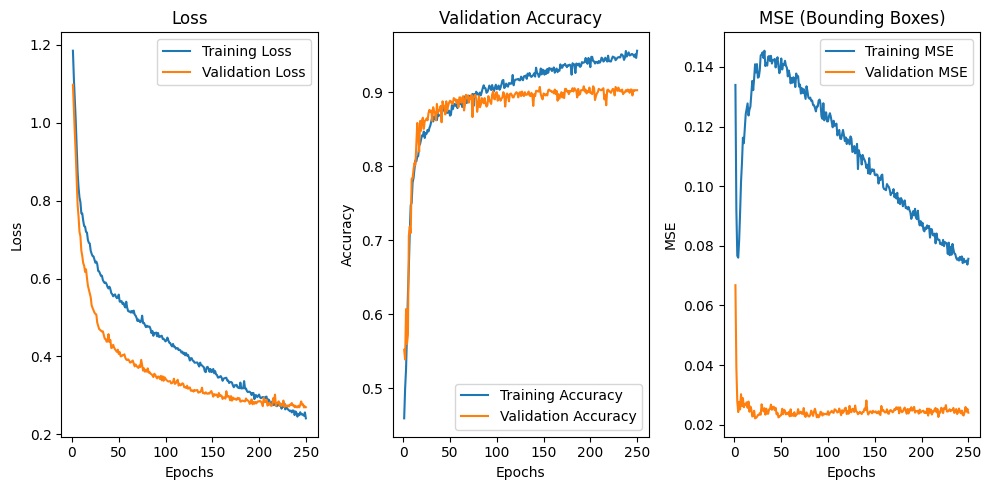

In [ ]:
# Llamar a la función después de entrenar el modelo
graficas_metricas(historyOne)

In [ ]:
def carga_preparacion_de_imagen(image_path, image_size=TAMANO_IMAGEN):
    # Cargar la imagen
    image = cv2.imread(image_path)
    # Redimensionar a tamaño compatible con el modelo
    image_resized = cv2.resize(image, (image_size, image_size))
    # Normalizar la imagen
    image_normalizado = image_resized.astype(float) / 255.0
    # Añadir un eje para que sea compatible con el modelo
    image_normalizado = np.expand_dims(image_normalizado, axis=0)
    return image, image_normalizado

In [ ]:
def prediccion_dibujo_de_bounding_box(image_path, model):
    # Cargar y preparar la imagen
    original_image, image_input = carga_preparacion_de_imagen(image_path)

    # Realizar la predicción
    predictions = model.predict(image_input)

    # Extraer las predicciones de clase y bounding boxes
    predicted_class = np.argmax(predictions[0][0])  # Clases predichas en la primera salida
    predicted_bboxes = predictions[1][0]  # Bounding boxes predichos en la segunda salida

    # Dibujar el bounding box en la imagen original
    height, width, _ = original_image.shape
    xmin = int(predicted_bboxes[0] * width)
    ymin = int(predicted_bboxes[1] * height)
    xmax = int(predicted_bboxes[2] * width)
    ymax = int(predicted_bboxes[3] * height)

    # Dibujar el bounding box
    cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Determinar el nombre de la clase predicha
    label = f'Tomate {predicted_class}'  # Ajusta el formato del label según las clases entrenadas
    cv2.putText(original_image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Interpretar los resultados de la predicción
    predicted_class = np.argmax(predictions[0], axis=-1)  # Si es una clasificación
    confidence = np.max(predictions[0])  # Probabilidad o confianza en la predicción

    # Mostrar la clase predicha y su probabilidad
    print(f'Predicted class: {predicted_class}, Confidence: {confidence:.2f}')

    # Mostrar la imagen con el bounding box
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: [2], Confidence: 0.99


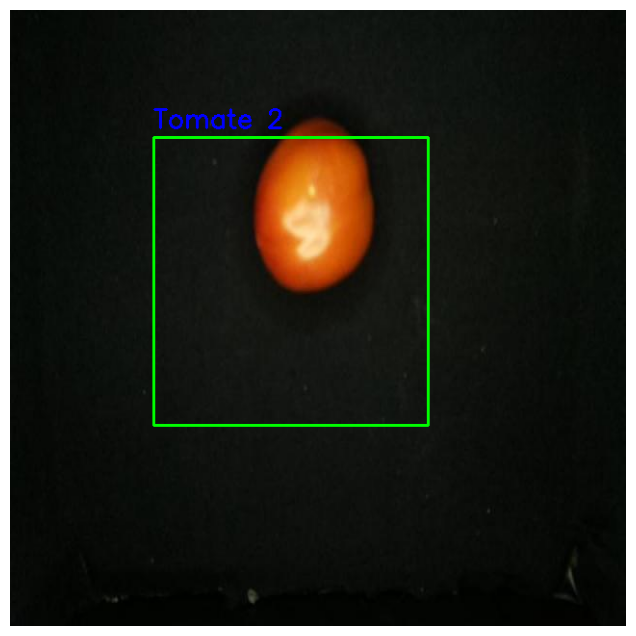

In [ ]:
#prediccion_dibujo_de_bounding_box('/content/drive/MyDrive/Colab Notebooks/Classification/TomClassObj.v2i.voc/valid/Muestra63_1_jpg.rf.3eea8731243bd709f6ad1b60a9ff12ec.jpg', model)
prediccion_dibujo_de_bounding_box('/content/drive/MyDrive/Colab_Notebooks/Classification/DatasetSuper/PruebasImg/Muestra101_4_jpg.rf.f066ac94f38b2a0411c048f65a13479b.jpg', model)

In [ ]:
# Guarda el modelo en el formato recomendado por Keras
#save_path = '/content/drive/MyDrive/Colab Notebooks/Classification/TomatoClass.keras'
#model.save(save_path)